<a href="https://colab.research.google.com/github/byronacunia/UFCA_estudo_mercado_livre/blob/main/UFCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analise Mercado Cativo

## Passo 1: Definição do tipo de Contrato

*   **Tipo de Contrato:** Vigencia única (Flat)
*   **Tipo de Consumidor:** Especial
*   **Energia Incentivada:** 50%, 80%, 100%



## Passo 2: Cálculo do valor da TUSD no cativo

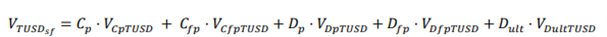

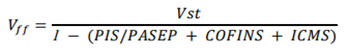

In [2]:
!git clone https://github.com/byronacunia/UFCA_estudo_mercado_livre.git

Cloning into 'UFCA_estudo_mercado_livre'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 51 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer

In [4]:
abas_de_excel =  pd.ExcelFile("/content/UFCA_estudo_mercado_livre/Raw Data/UFCA.xlsx")
abas_de_excel.sheet_names

['Apresentação', 'UC1', 'UC2', 'UC3', 'UC4']

In [5]:
UC1 = abas_de_excel.parse("UC1")
UC2 = abas_de_excel.parse("UC2")
UC3 = abas_de_excel.parse("UC3")
UC4 = abas_de_excel.parse("UC4")

In [6]:
def TOTAL_CONTA_CATIVO_UC(dadosDF,Tarifa_total_P , Tarifa_total_FP, RetencaoFederal ):
  TUSD_FP=Tarifa_total_FP*0.22  #22% Dado da Concecionaria a ser atualizado
  TUSD_P=Tarifa_total_P*0.74    #74% Dado da Concecionaria a ser atualizado
  TE_FP=Tarifa_total_FP-TUSD_FP
  TE_P= Tarifa_total_P-TUSD_P
  dadosDF['Differença Demanda'] = dadosDF['DEMANDA_REGISTRADA_FP'] - dadosDF['DEMANDA_CONTRATADA_P']
  dadosDF['Valor Demanda'] = (dadosDF['DEMANDA_REGISTRADA_FP'] * dadosDF['TAR_TUSD_KW_FP']) +(dadosDF['Differença Demanda'] *-1* dadosDF['TAR_DEMANDA_FP_SEM ICMS'])
  dadosDF['Valor Consumo P+FP TUSD'] = (TUSD_FP*dadosDF['ENERGIA_FPONTA'])+(TUSD_P*dadosDF['ENERGIA_PONTA'])
  dadosDF['Valor Consumo TE'] = (TE_FP*dadosDF['ENERGIA_FPONTA'])+(TE_P*dadosDF['ENERGIA_PONTA'])
  dadosDF['Valor da conta no cativo'] = (dadosDF['Valor Demanda']+dadosDF['Valor Consumo P+FP TUSD']+dadosDF['Valor Consumo TE'])-((dadosDF['Valor Demanda']+dadosDF['Valor Consumo P+FP TUSD']+dadosDF['Valor Consumo TE'])*RetencaoFederal)
  dadosDF['Valor consumo TUSD_FP']= (TUSD_FP*dadosDF['ENERGIA_FPONTA'])
  dadosDF['Valor consumo TUSD_P']= (TUSD_P*dadosDF['ENERGIA_PONTA'])
  TOTAL_CONTA_CATIVO = dadosDF['Valor da conta no cativo'].sum()
  #dadosDF.head()
  return TOTAL_CONTA_CATIVO, dadosDF

In [7]:
def Analise_de_Mercado_Livre(ANO, Valor_Energia_MWh, UCs):
  Cativo = 0
  lista_UCs = []
  TUSD_Demanda_50parecela = 0
  TUSD_Consumo_4855parecela = 0
  TUSD_Consumo_9711parecela = 0
  Consumo_Total = 0  
  for UC_E in UCs:
    dadosUC_E = UC_E[UC_E['ANO']==ANO][['DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
    del dadosUC_E['index']
    dadosUC_E = dadosUC_E.fillna(method='ffill')
    TOTAL_CONTA_CATIVO_UC_E, dadosUC_E = TOTAL_CONTA_CATIVO_UC(dadosUC_E,Tarifa_total_P=1.81318, Tarifa_total_FP = 0.40733, RetencaoFederal = 0.0620)
    lista_UCs.append(dadosUC_E)
    Cativo = TOTAL_CONTA_CATIVO_UC_E + Cativo
    TUSD_Demanda_50parecela = (dadosUC_E['Valor Demanda']* 0.5) + TUSD_Demanda_50parecela #TUSD Demanda 50% Parcela
    TUSD_Consumo_4855parecela = (dadosUC_E['Valor consumo TUSD_FP'] - (dadosUC_E['Valor consumo TUSD_FP'] * 0.4855 )) + dadosUC_E['Valor consumo TUSD_P'] + TUSD_Consumo_4855parecela #TUSD consumo 48.55%
    TUSD_Consumo_9711parecela = (dadosUC_E['Valor consumo TUSD_FP'] - (dadosUC_E['Valor consumo TUSD_FP'] * 0.9711 )) + dadosUC_E['Valor consumo TUSD_P'] + TUSD_Consumo_9711parecela #TUSD consumo 97.11%
    Consumo_Total=dadosUC_E['ENERGIA_PONTA']+dadosUC_E['ENERGIA_FPONTA'] + Consumo_Total
  print("Cativo = R$",Cativo, "do ano = ", ANO)
  TUSD_TOTAL_50=TUSD_Demanda_50parecela+TUSD_Consumo_4855parecela
  Conta_ML_50=TUSD_TOTAL_50+((Valor_Energia_MWh/1000)*Consumo_Total)
  Livre50=Conta_ML_50.sum()#TOTAL_Conta_ML_50
  print("Livre 50% = R$",Livre50, "do ano = ", ANO)
  TUSD_TOTAL_100=0+TUSD_Consumo_9711parecela #TUSD demanda 100% parcela = 0
  TUSD_TOTAL_100=0+TUSD_Consumo_9711parecela #TUSD demanda 100% parcela = 0
  Conta_ML_100=TUSD_TOTAL_100+((Valor_Energia_MWh/1000)*Consumo_Total)
  Livre100=Conta_ML_100.sum()#TOTAL_Conta_ML_100
  print("Livre 100% = R$",Livre100, "do ano = ", ANO)
  print("Econômia livre 50% = R$",Cativo-Livre50)
  print("Econômia livre 100% = R$",Cativo-Livre100)
  return Cativo, Livre50, Livre100


#Dados de Entrada UC1

In [60]:
dadosUC1 = UC1[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC1['index']
dadosUC1    

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,139,81.00,7.44000,NaN,10180,792
1,Outubro,2014,139,123.00,8.51000,NaN,18783,1562
2,Novembro,2014,139,133.00,7.74000,NaN,21323,1748
3,Dezembro,2014,139,133.00,7.36000,NaN,16324,1393
4,Janeiro,2015,139,118.00,7.32000,NaN,17178,1359
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,139,105.00,21.46590,15.54059,26620,2316
65,Fevereiro,2020,139,86.94,22.93628,16.29677,14305,942
66,Março,2020,139,154.56,22.84343,NaN,17622,1345
67,Abril,2020,139,154.98,20.82185,NaN,15948,1451


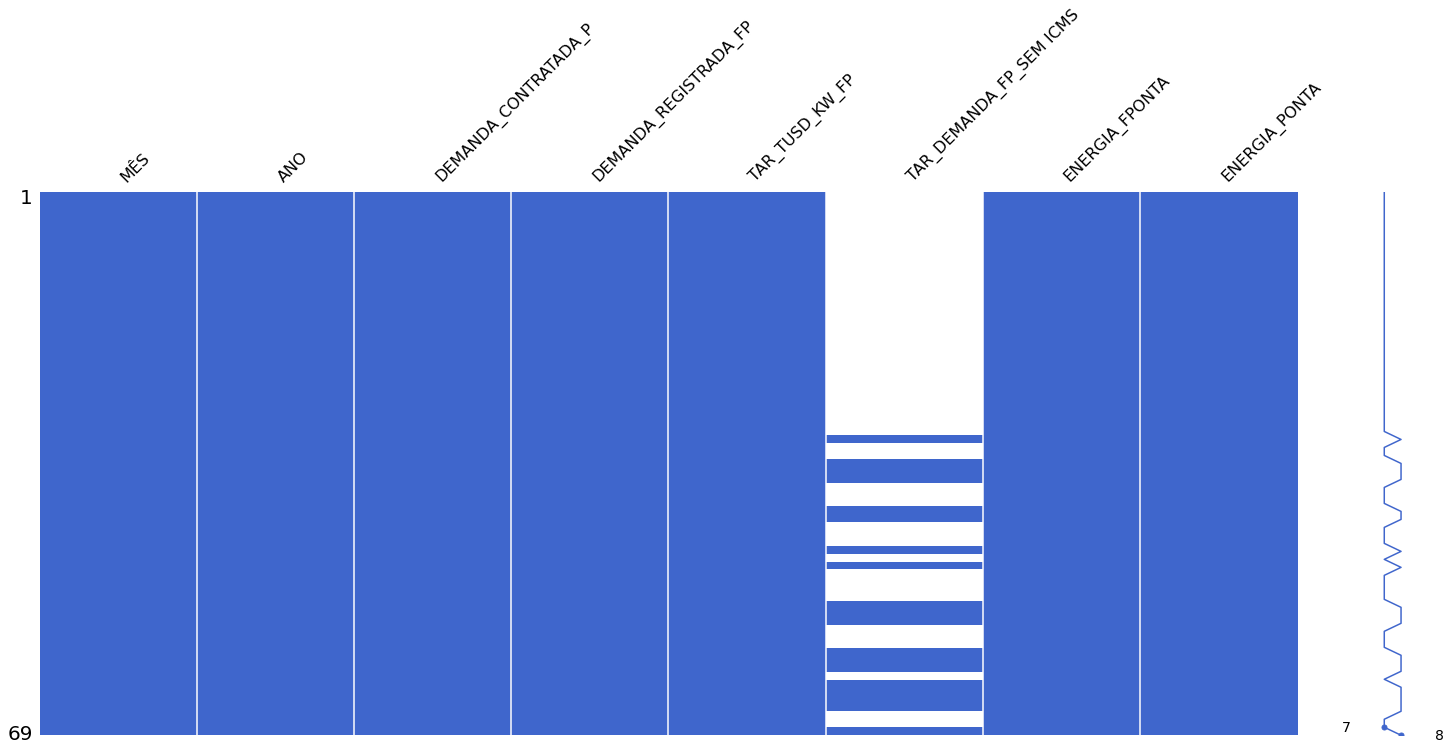

In [61]:
msno.matrix(dadosUC1, color = (0.25,0.4,0.8))

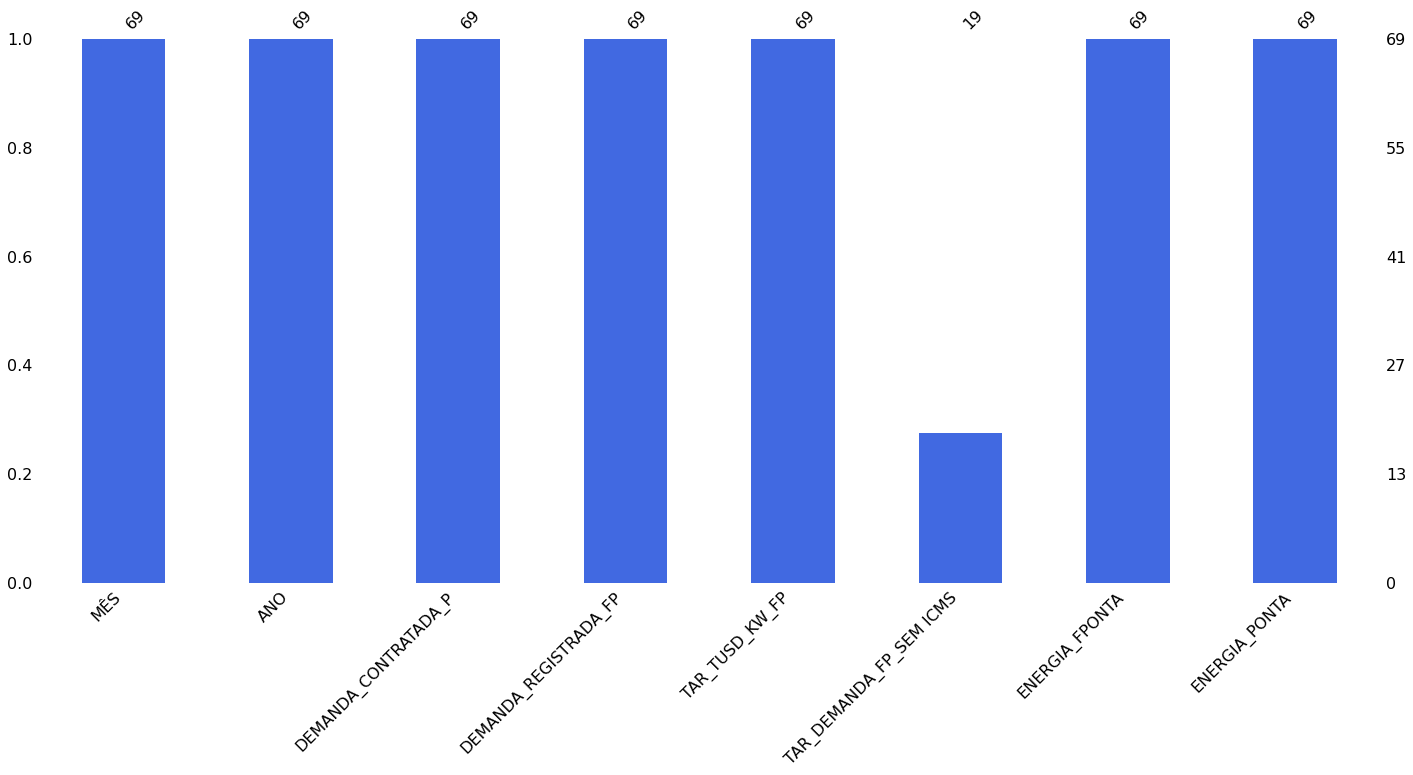

In [62]:
msno.bar(dadosUC1, color="RoyalBlue")

##Imputação de dados de Entrada da UC1

In [63]:
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC1[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC1['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC1[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

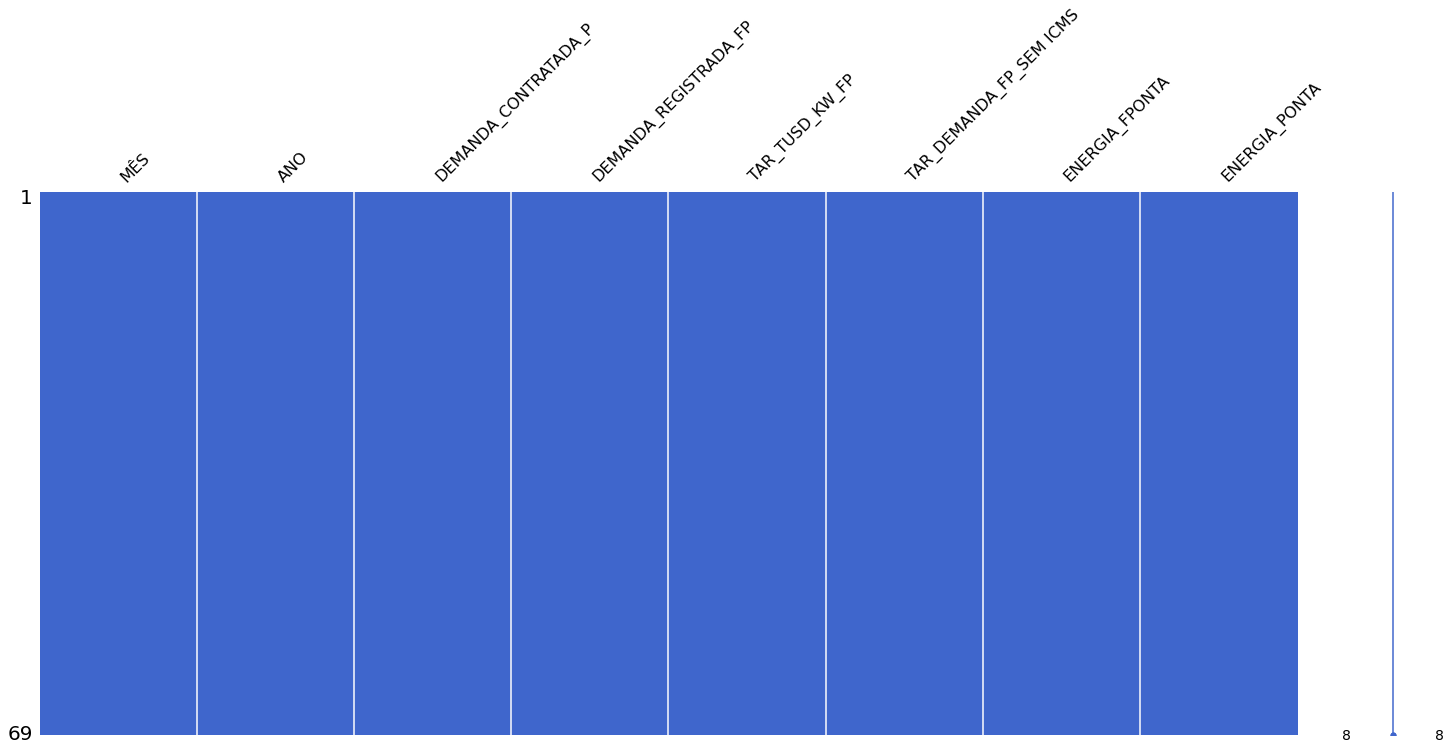

In [64]:
msno.matrix(dadosUC1, color = (0.25,0.4,0.8))

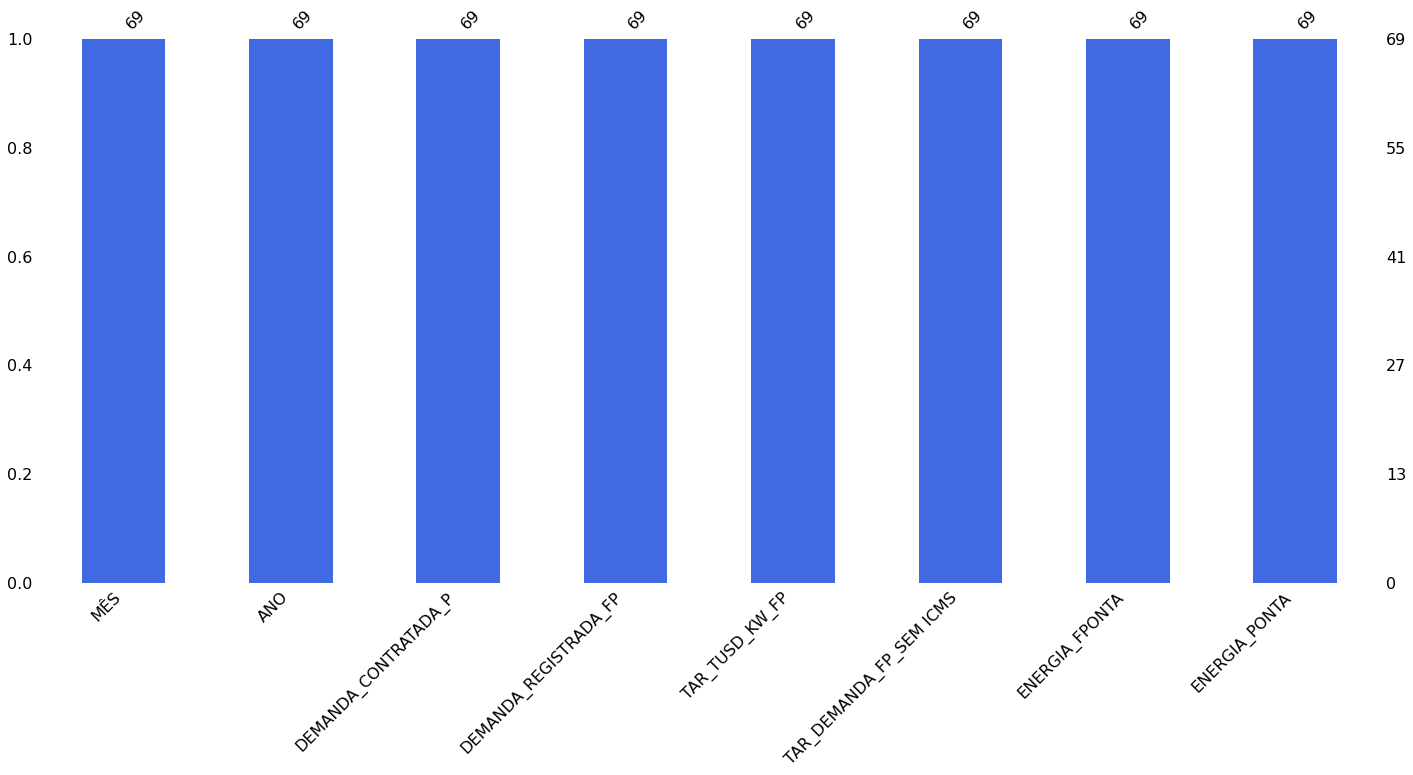

In [65]:
msno.bar(dadosUC1, color="RoyalBlue")

In [66]:
dadosUC1

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,139,81.00,7.44000,0.00000,10180,792
1,Outubro,2014,139,123.00,8.51000,0.00000,18783,1562
2,Novembro,2014,139,133.00,7.74000,0.00000,21323,1748
3,Dezembro,2014,139,133.00,7.36000,0.00000,16324,1393
4,Janeiro,2015,139,118.00,7.32000,0.00000,17178,1359
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,139,105.00,21.46590,15.54059,26620,2316
65,Fevereiro,2020,139,86.94,22.93628,16.29677,14305,942
66,Março,2020,139,154.56,22.84343,0.00000,17622,1345
67,Abril,2020,139,154.98,20.82185,0.00000,15948,1451


#Dados de Entrada UC2

In [67]:
dadosUC2 = UC2[['MÊS','ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC2['index']
dadosUC2

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,63.0,54.00,NaN,NaN,6999.0,569.0
1,Outubro,2014,63.0,70.00,NaN,NaN,12448.0,751.0
2,Novembro,2014,63.0,70.00,7.74000,NaN,13327.0,857.0
3,Dezembro,2014,63.0,70.00,7.36000,NaN,9740.0,627.0
4,Janeiro,2015,63.0,53.00,7.32000,NaN,6978.0,468.0
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,160.0,85.00,21.46588,15.54040,24811.0,1753.0
65,Fevereiro,2020,160.0,66.36,22.93641,16.29667,14403.0,1302.0
66,Março,2020,160.0,91.14,22.84321,16.24964,14740.0,1171.0
67,Abril,2020,160.0,77.70,20.82188,15.20000,9406.0,955.0


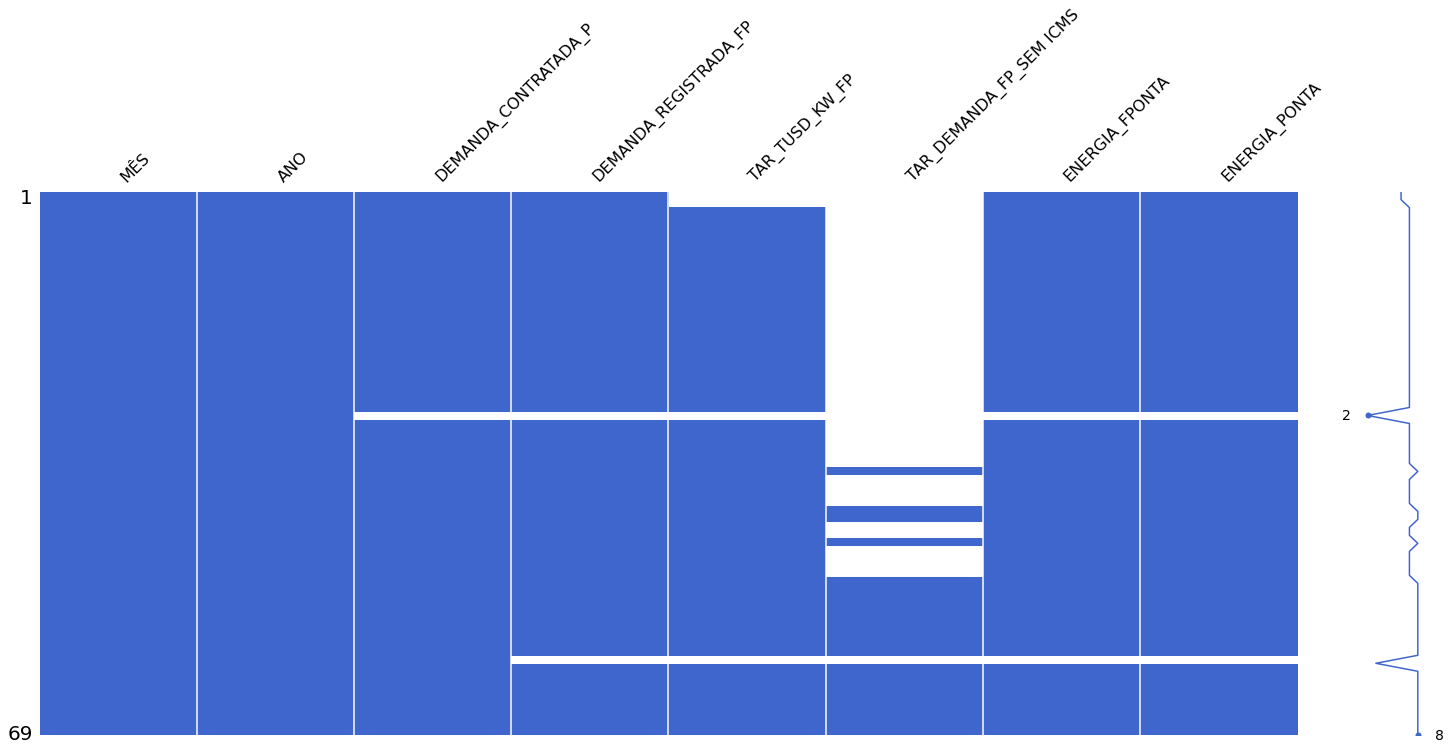

In [68]:
msno.matrix(dadosUC2, color = (0.25,0.4,0.8))

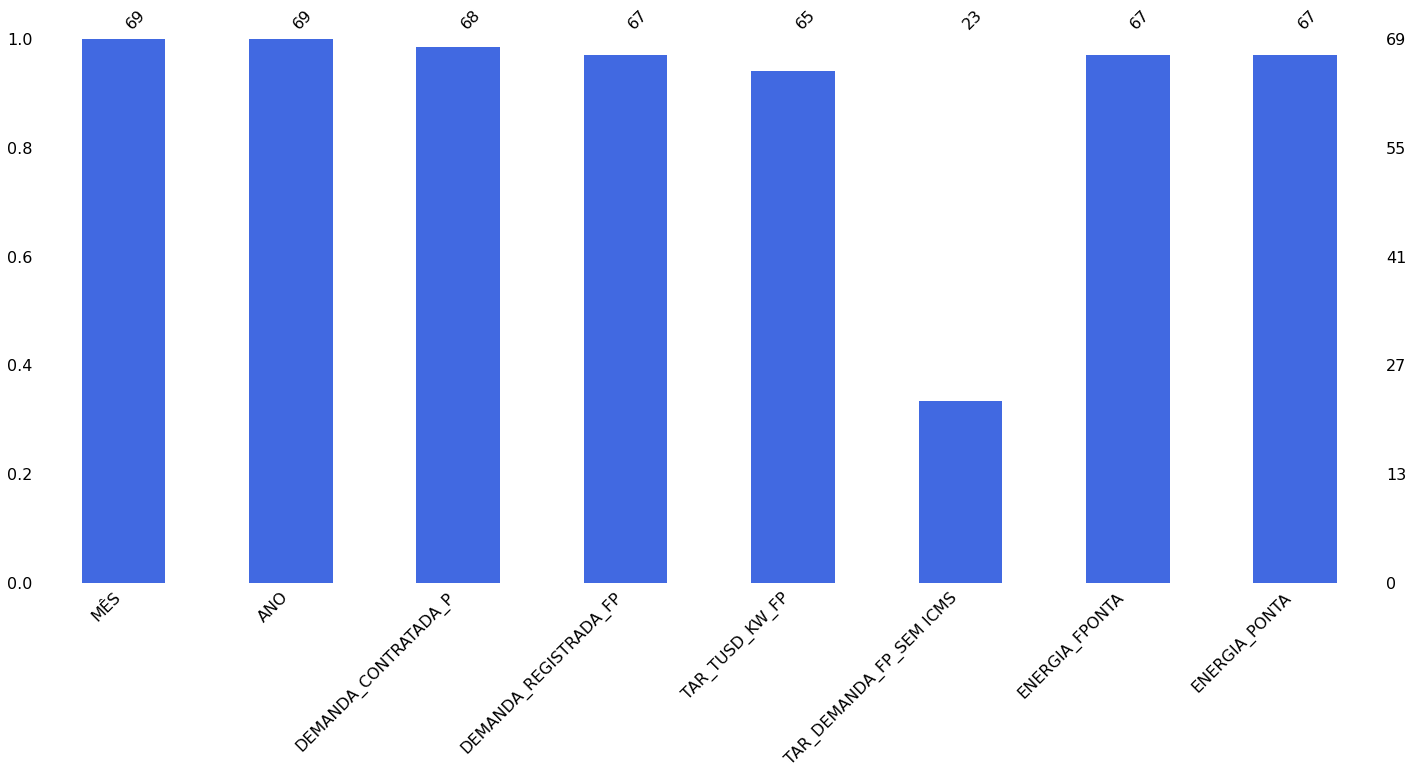

In [69]:
msno.bar(dadosUC2, color="RoyalBlue")

##Imputação de dados de Entrada da UC2

In [70]:
#Imputação da "TAR_DEMANDA_FP_SEM ICMS"
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC2[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC2['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC2[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

#Imputação da "DEMANDA_CONTRATADA_P"
dadosUC2['DEMANDA_CONTRATADA_P'] = dadosUC2['DEMANDA_CONTRATADA_P'].fillna(method='ffill')

#Imputação da "TAR_TUSD_KW_FP"
dadosUC2['TAR_TUSD_KW_FP'] = dadosUC2['TAR_TUSD_KW_FP'].fillna(method='bfill')

#Imputação da "DEMANDA_REGISTRADA_FP"
dadosUC2['DEMANDA_REGISTRADA_FP'] = dadosUC2['DEMANDA_REGISTRADA_FP'].fillna(method='ffill')

#Imputação da "ENERGIA_FPONTA"
dadosUC2['ENERGIA_FPONTA'] = dadosUC2['ENERGIA_FPONTA'].fillna(method='ffill')

#Imputação da "ENERGIA_PONTA"
dadosUC2['ENERGIA_PONTA'] = dadosUC2['ENERGIA_PONTA'].fillna(method='ffill')


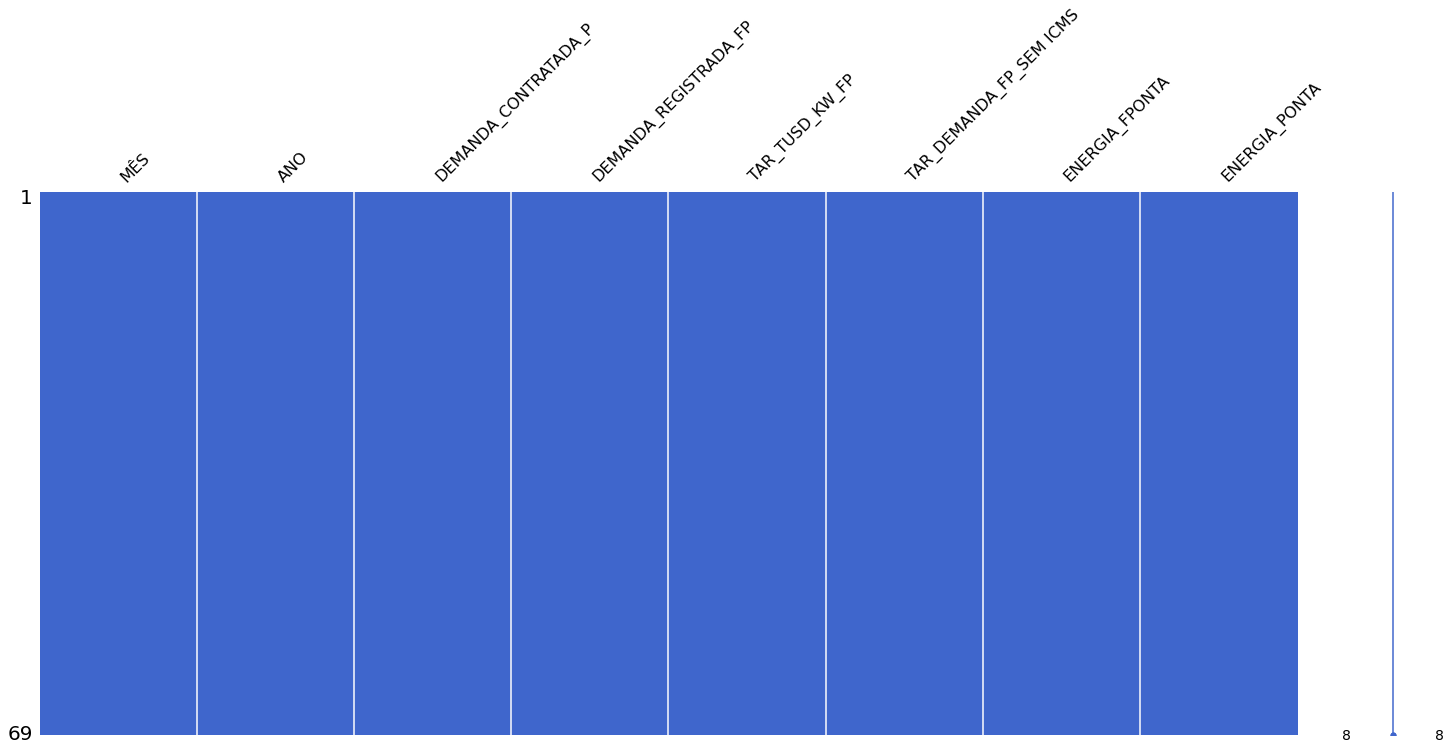

In [71]:
msno.matrix(dadosUC2, color = (0.25,0.4,0.8))

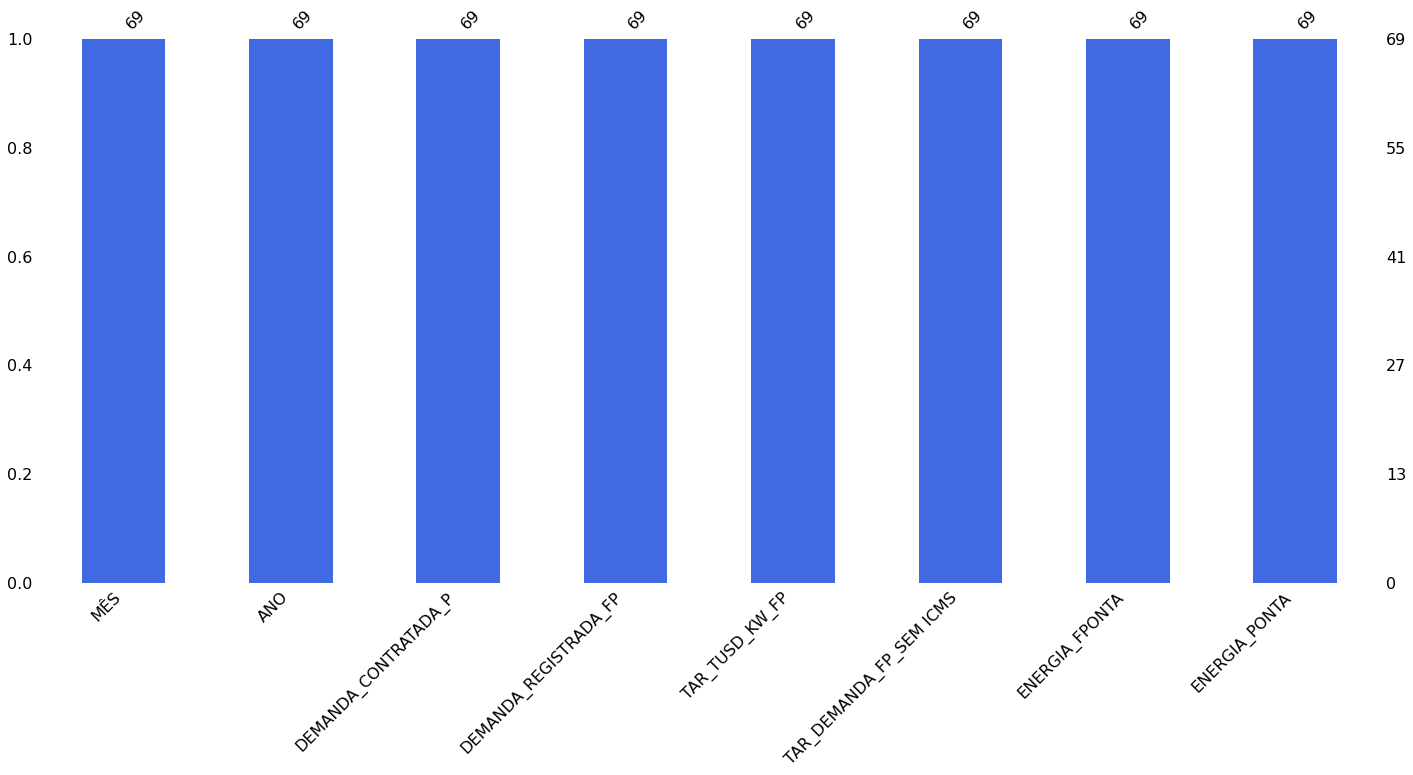

In [72]:
msno.bar(dadosUC2, color="RoyalBlue")


In [73]:
dadosUC2

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,63.0,54.00,7.74000,0.00000,6999.0,569.0
1,Outubro,2014,63.0,70.00,7.74000,0.00000,12448.0,751.0
2,Novembro,2014,63.0,70.00,7.74000,0.00000,13327.0,857.0
3,Dezembro,2014,63.0,70.00,7.36000,0.00000,9740.0,627.0
4,Janeiro,2015,63.0,53.00,7.32000,0.00000,6978.0,468.0
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,160.0,85.00,21.46588,15.54040,24811.0,1753.0
65,Fevereiro,2020,160.0,66.36,22.93641,16.29667,14403.0,1302.0
66,Março,2020,160.0,91.14,22.84321,16.24964,14740.0,1171.0
67,Abril,2020,160.0,77.70,20.82188,15.20000,9406.0,955.0


#Dados de Entrada UC3

In [74]:
dadosUC3 = UC3[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC3['index']
dadosUC3   

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,out,2014,257,294.00,8.51000,NaN,55737,9178
1,nov,2014,257,302.00,7.74000,NaN,63123,9721
2,dez,2014,257,302.00,7.36000,NaN,43760,7072
3,jan,2015,257,143.00,7.32000,NaN,26793,1039
4,fev,2015,257,181.00,7.57000,NaN,33321,2520
...,...,...,...,...,...,...,...,...
64,jan,2020,600,489.00,21.46589,15.54027,117522,13778
65,fev,2020,600,330.96,22.93646,16.29676,72404,6224
66,mar,2020,600,470.40,22.84341,16.24977,81416,8723
67,abr,2020,600,498.96,20.82191,15.20002,53588,6836


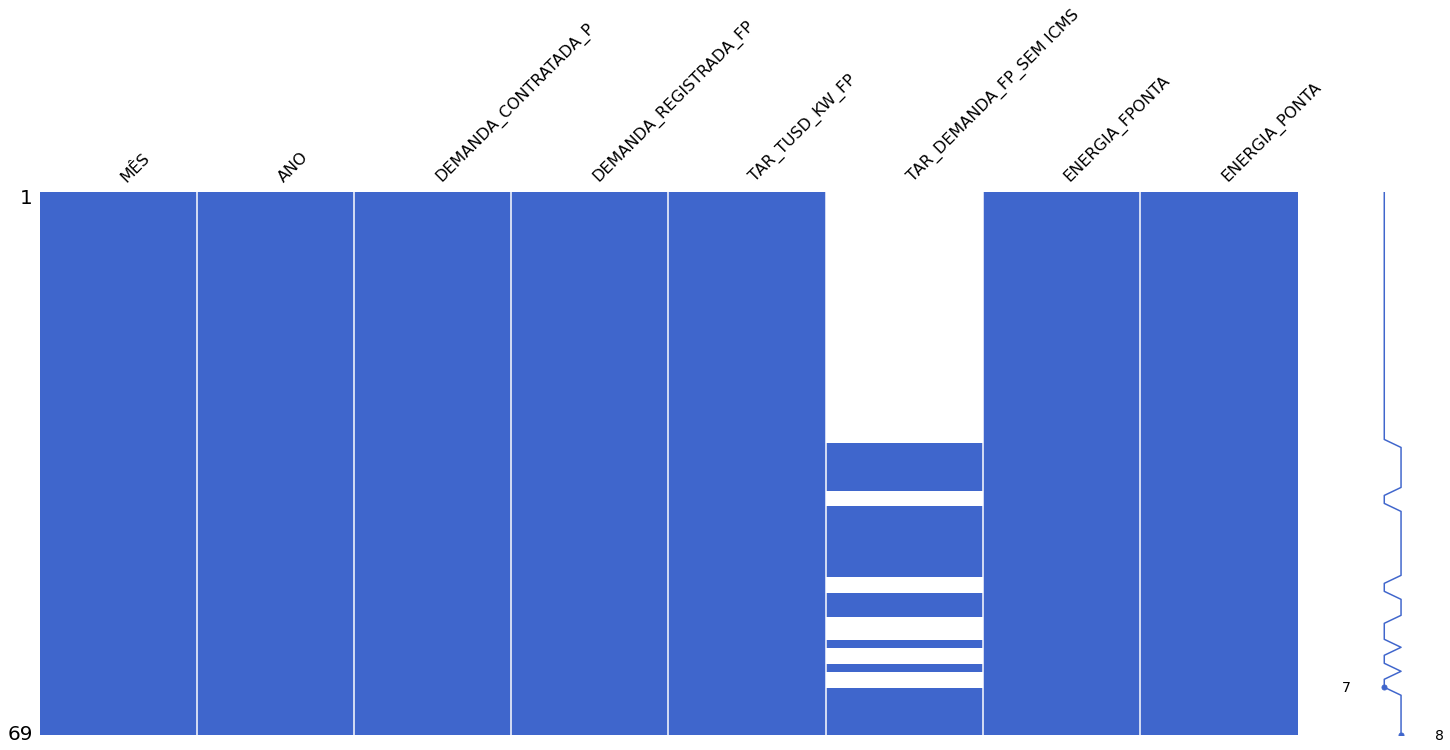

In [76]:
msno.matrix(dadosUC3, color = (0.25,0.4,0.8))

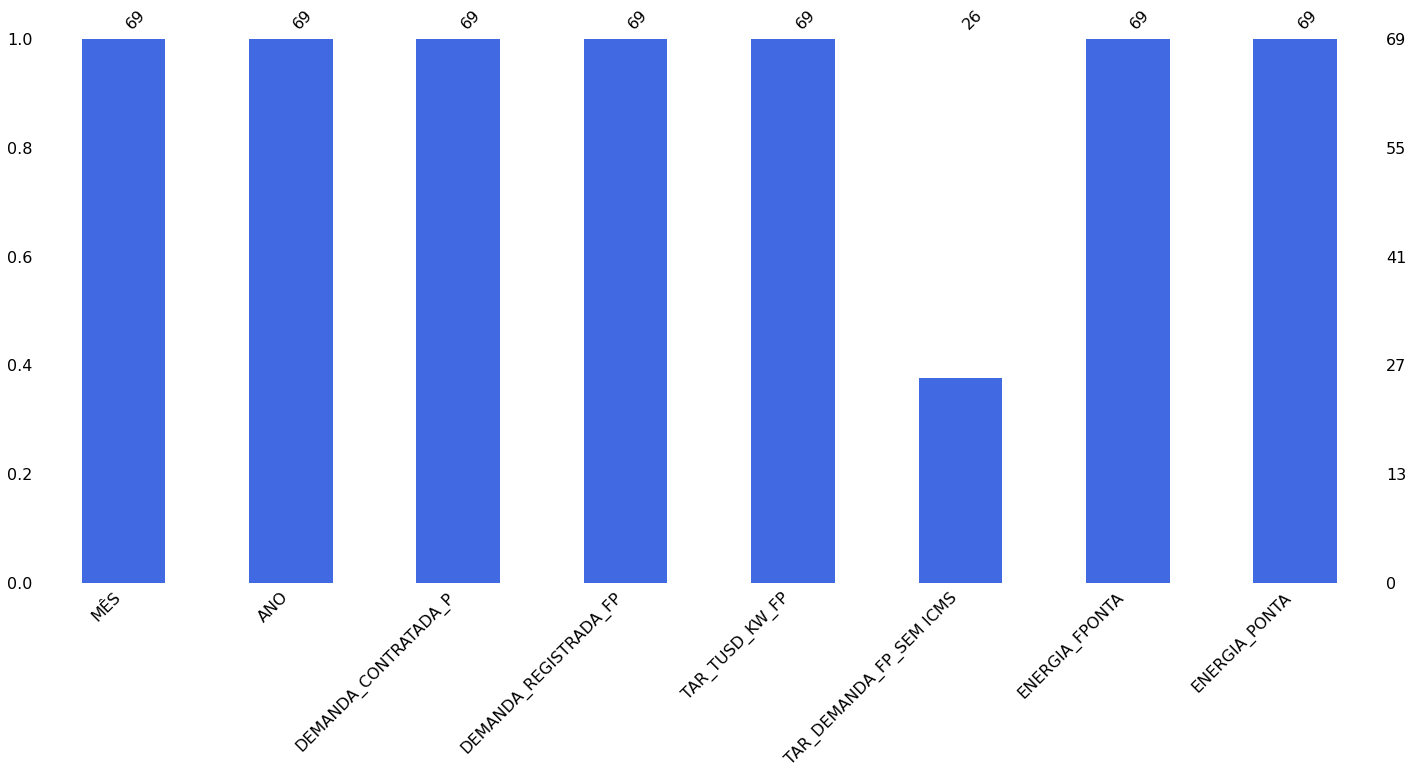

In [77]:
msno.bar(dadosUC3, color="RoyalBlue")

##Imputação de dados de Entrada da UC3

In [78]:
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC3[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC3['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC3[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

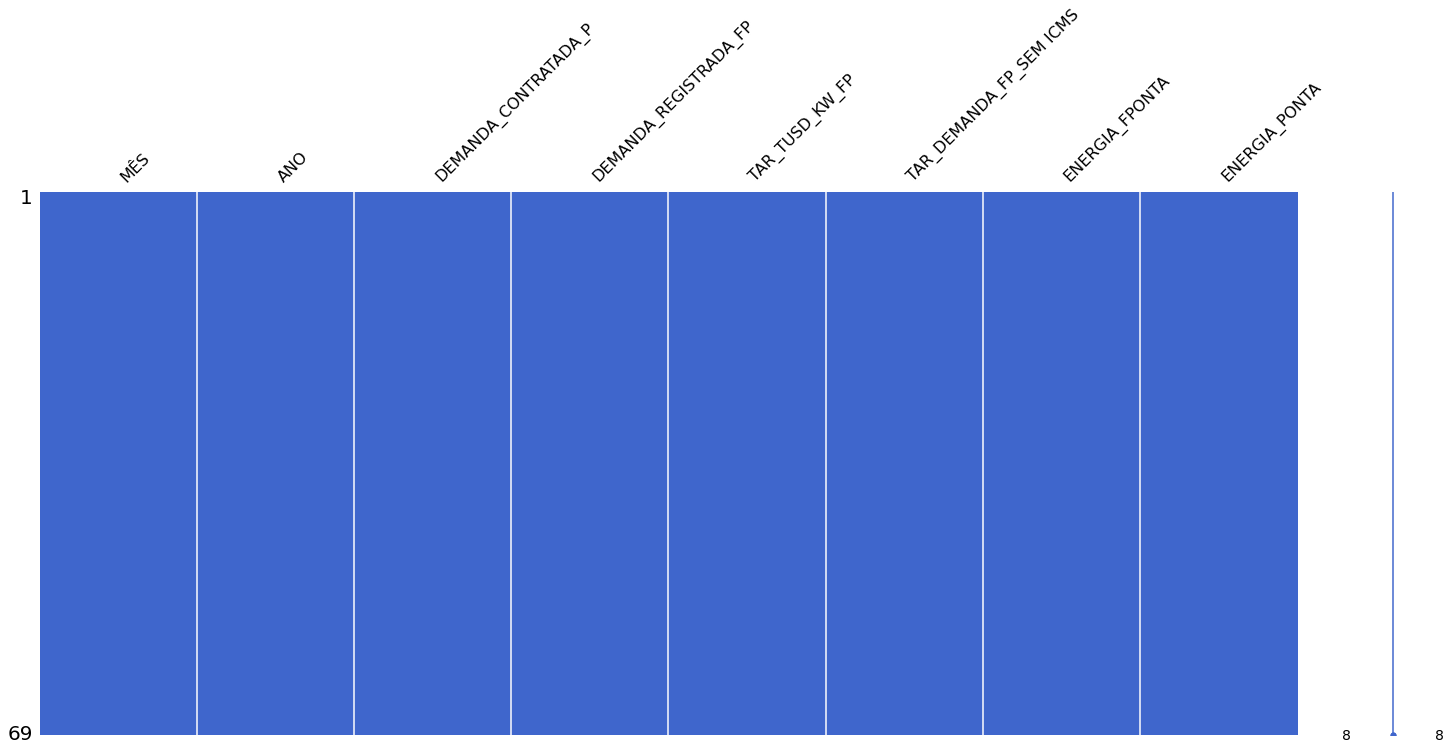

In [81]:
msno.matrix(dadosUC3, color = (0.25,0.4,0.8))

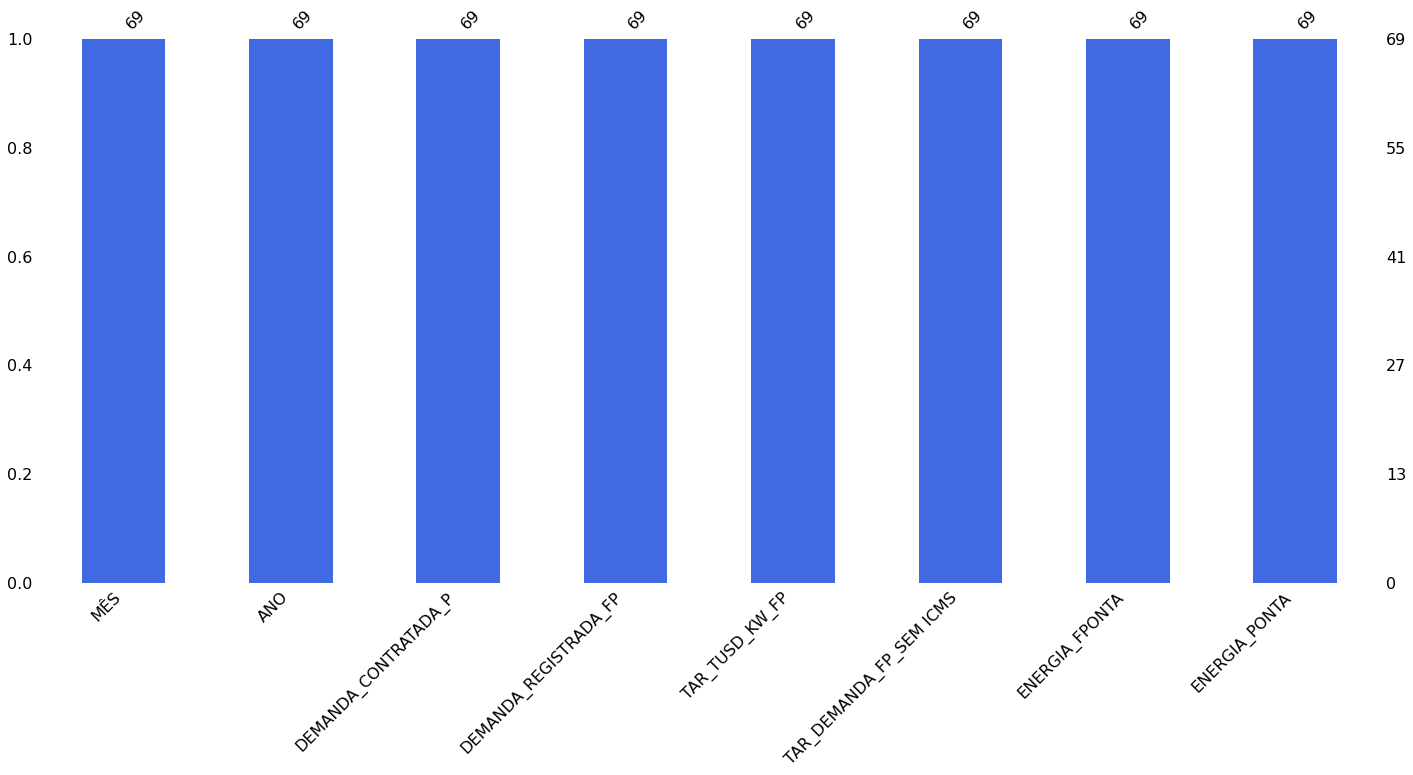

In [82]:
msno.bar(dadosUC3, color="RoyalBlue")

In [83]:
dadosUC3

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,out,2014,257,294.00,8.51000,0.00000,55737,9178
1,nov,2014,257,302.00,7.74000,0.00000,63123,9721
2,dez,2014,257,302.00,7.36000,0.00000,43760,7072
3,jan,2015,257,143.00,7.32000,0.00000,26793,1039
4,fev,2015,257,181.00,7.57000,0.00000,33321,2520
...,...,...,...,...,...,...,...,...
64,jan,2020,600,489.00,21.46589,15.54027,117522,13778
65,fev,2020,600,330.96,22.93646,16.29676,72404,6224
66,mar,2020,600,470.40,22.84341,16.24977,81416,8723
67,abr,2020,600,498.96,20.82191,15.20002,53588,6836


#Dados de Entrada UC4

In [84]:
dadosUC4 = UC4[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC4['index']
dadosUC4   

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,jan,2017,60,4.00,10.47000,NaN,NaN,NaN
1,fev,2017,60,4.00,10.47000,NaN,405.0,NaN
2,mar,2017,60,3.00,10.52000,NaN,1001.0,NaN
3,abr,2017,83,4.00,10.48000,NaN,979.0,NaN
4,mai,2017,30,6.00,17.56000,NaN,810.0,NaN
5,jun,2017,30,4.00,18.14000,NaN,908.0,102.0
6,jul,2017,30,3.00,17.45000,NaN,842.0,118.0
7,ago,2017,30,4.00,17.30000,NaN,860.0,136.0
8,set,2017,30,4.00,17.86000,12.73269,955.0,141.0
9,out,2017,30,5.00,17.60000,12.60000,1098.0,153.0


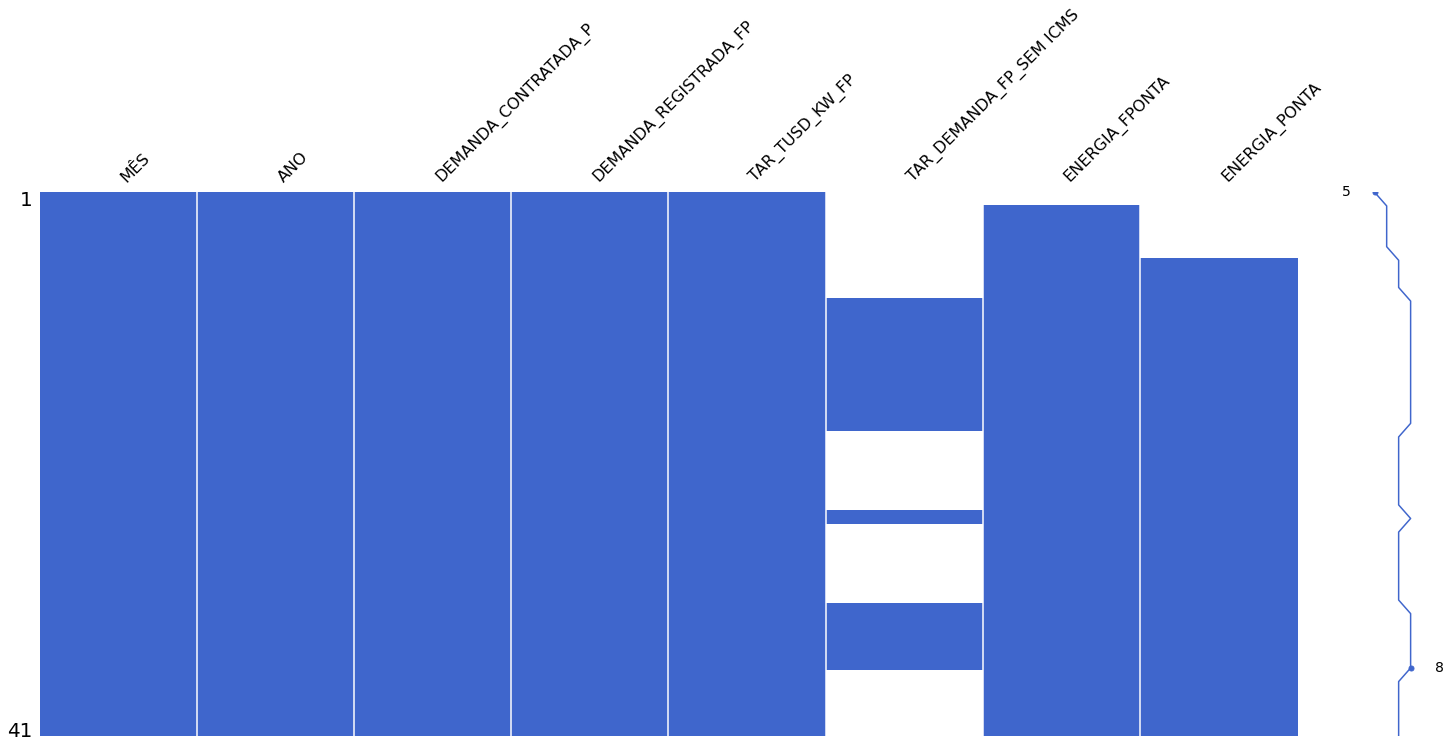

In [85]:
msno.matrix(dadosUC4, color = (0.25,0.4,0.8))

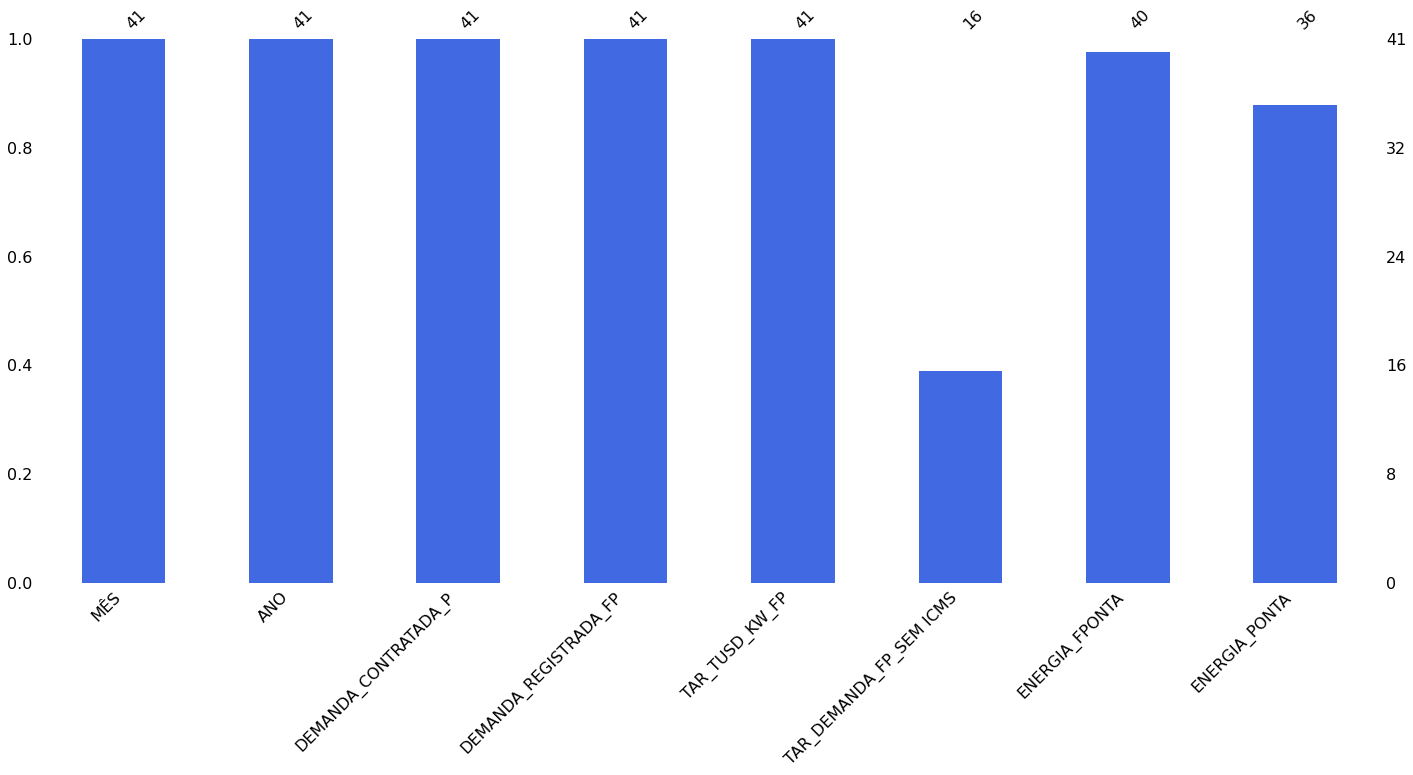

In [87]:
msno.bar(dadosUC4, color="RoyalBlue")

##Imputação de dados de Entrada da UC4

In [93]:
#Imputação da "TAR_DEMANDA_FP_SEM ICMS"
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC4[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC4['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC4[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

#Imputação da "ENERGIA_FPONTA"
dadosUC4['ENERGIA_FPONTA'] = dadosUC4['ENERGIA_FPONTA'].fillna(method='bfill')

#Imputação da "ENERGIA_PONTA"
dadosUC4['ENERGIA_PONTA'] = dadosUC4['ENERGIA_PONTA'].fillna(method='bfill')

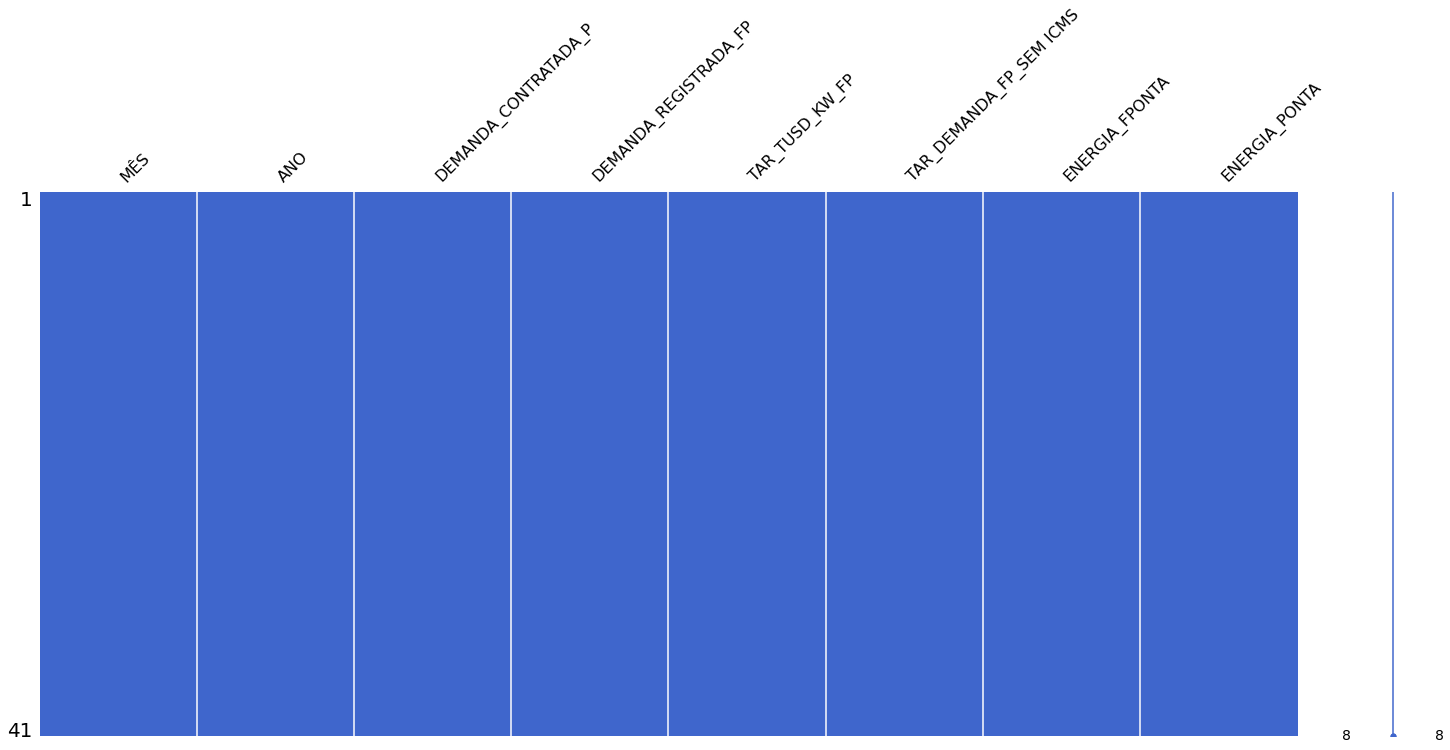

In [94]:
msno.matrix(dadosUC4, color = (0.25,0.4,0.8))

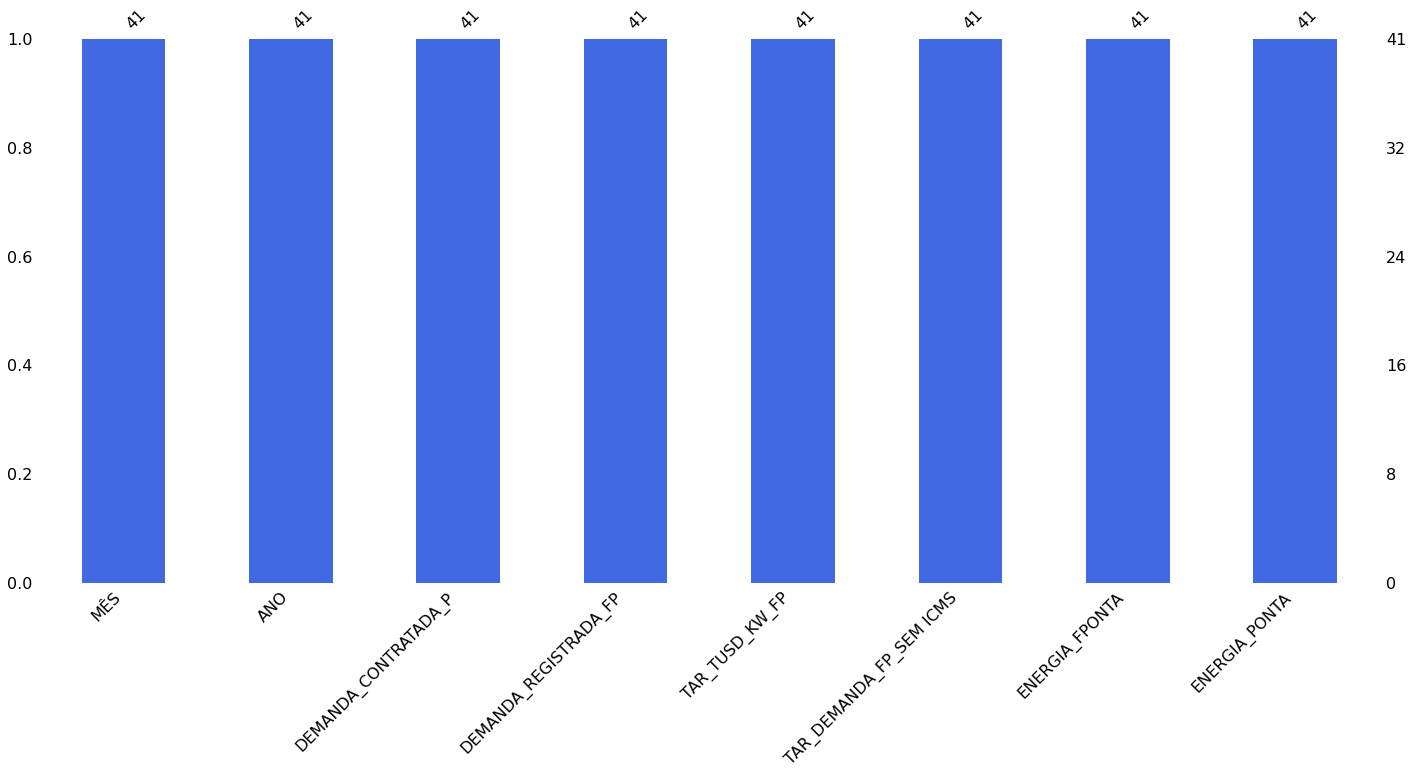

In [96]:
msno.bar(dadosUC4, color="RoyalBlue")

In [98]:
dadosUC4

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,jan,2017,60,4.00,10.47000,0.00000,405.0,102.0
1,fev,2017,60,4.00,10.47000,0.00000,405.0,102.0
2,mar,2017,60,3.00,10.52000,0.00000,1001.0,102.0
3,abr,2017,83,4.00,10.48000,0.00000,979.0,102.0
4,mai,2017,30,6.00,17.56000,0.00000,810.0,102.0
5,jun,2017,30,4.00,18.14000,0.00000,908.0,102.0
6,jul,2017,30,3.00,17.45000,0.00000,842.0,118.0
7,ago,2017,30,4.00,17.30000,0.00000,860.0,136.0
8,set,2017,30,4.00,17.86000,12.73269,955.0,141.0
9,out,2017,30,5.00,17.60000,12.60000,1098.0,153.0


#Analise de Mercado

In [99]:
UCs_input=[dadosUC1,dadosUC2,dadosUC3,dadosUC4]
Cativo_2019, Livre50_2019, Livre100_2019 = Analise_de_Mercado_Livre(ANO=2019, Valor_Energia_MWh=240,UCs=UCs_input)

Cativo = R$ 1148097.4362850133 do ano =  2019
Livre 50% = R$ 878931.1360767834 do ano =  2019
Livre 100% = R$ 702140.367115496 do ano =  2019
Econômia livre 50% = R$ 269166.3002082299
Econômia livre 100% = R$ 445957.0691695174


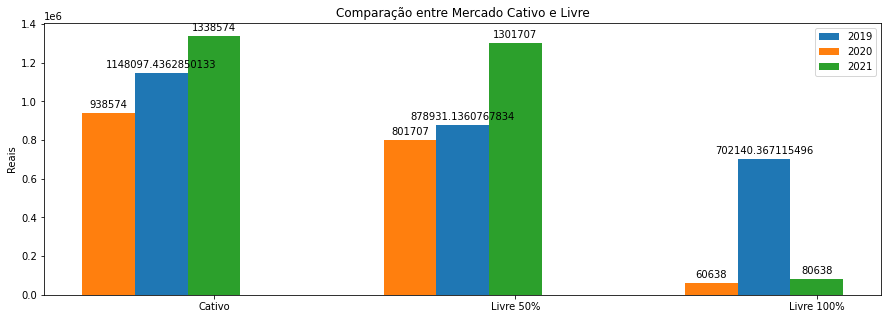

In [100]:
labels = ['Cativo', 'Livre 50%', 'Livre 100%']
Resultados_2019 = [Cativo_2019, Livre50_2019, Livre100_2019]
Resultados_2020 = [938574, 801707, 60638]
Resultados_2021 = [1338574, 1301707, 80638]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/2, Resultados_2019, width/2, label='2019')
rects2 = ax.bar(x - width, Resultados_2020, width/2, label='2020')
rects3 = ax.bar(x, Resultados_2021, width/2, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reais')
ax.set_title('Comparação entre Mercado Cativo e Livre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
#plt.figure(figsize=(40, 20))
#fig.tight_layout()
plt.show()